In [3]:
import torch
from mnist import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 128
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

obs_x, obs_y = get_observation_pixels()



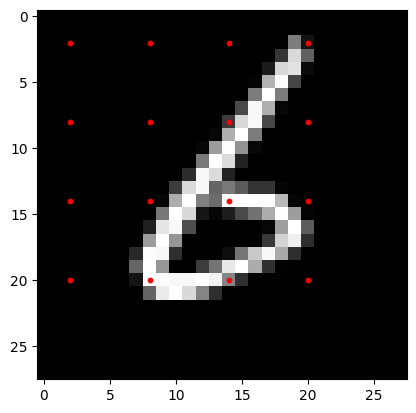

In [13]:
example = next(iter(test_loader))
plt.imshow(example[0][0][0].numpy(), cmap='gray')

for i in range(len(obs_x)):
    plt.scatter(obs_x[i], obs_y[i], c='r', s=10)
